
# Traffic Sign Classification in Google Colab
# **Step 1: Setup Environment**


In [1]:
#!/usr/bin/env python
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
from sklearn.model_selection import train_test_split
from collections import Counter

# **Step 2: Download & Prepare Dataset**

In [3]:
# Download dataset
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
!unzip -q GTSRB_Final_Training_Images.zip

--2025-03-22 15:05:52--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  14.5MB/s    in 22s     

2025-03-22 15:06:15 (12.2 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [4]:
# ----------------------------
# 1. Define the Custom Dataset
# ----------------------------
class GTSRBDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and class subdirectories.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        # Loop over each class directory inside the root directory
        for class_folder in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_folder)
            if not os.path.isdir(class_path):
                continue
            # Look for CSV annotation file (named like GT-<ClassID>.csv)
            csv_files = [f for f in os.listdir(class_path) if f.endswith('.csv')]
            if len(csv_files) == 0:
                continue
            csv_path = os.path.join(class_path, csv_files[0])
            # Read CSV file (using semicolon as delimiter)
            annotations = pd.read_csv(csv_path, sep=';')
            for _, row in annotations.iterrows():
                img_filename = row['Filename']
                label = int(row['ClassId'])
                img_path = os.path.join(class_path, img_filename)
                self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path)
        if image.mode != "RGB":
            image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

## Data Transformations & Loading Dataset

In [5]:
# ----------------------------
# 2. Define Data Transforms & Load Dataset
# ----------------------------
data_transforms = transforms.Compose([
    transforms.Resize((32, 32)),   # Resize images to 32x32 pixels
    transforms.ToTensor(),         # Convert PIL images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Create the dataset (update 'path_to/Images' to your local path)
dataset = GTSRBDataset(root_dir="/content/GTSRB/Final_Training/Images", transform=data_transforms)

## Split Dataset into Training, Validation, and Testing Sets

In [6]:
# ----------------------------
# 3. Split Dataset into Training, Validation, and Testing Sets
# ----------------------------
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Calculate sizes for each split
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size

# Perform the split
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

# Create DataLoaders for each split
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Training Size: {train_size}, Validation Size: {val_size}, Testing Size: {test_size}")


Training Size: 31367, Validation Size: 3920, Testing Size: 3922


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Dataset visualization

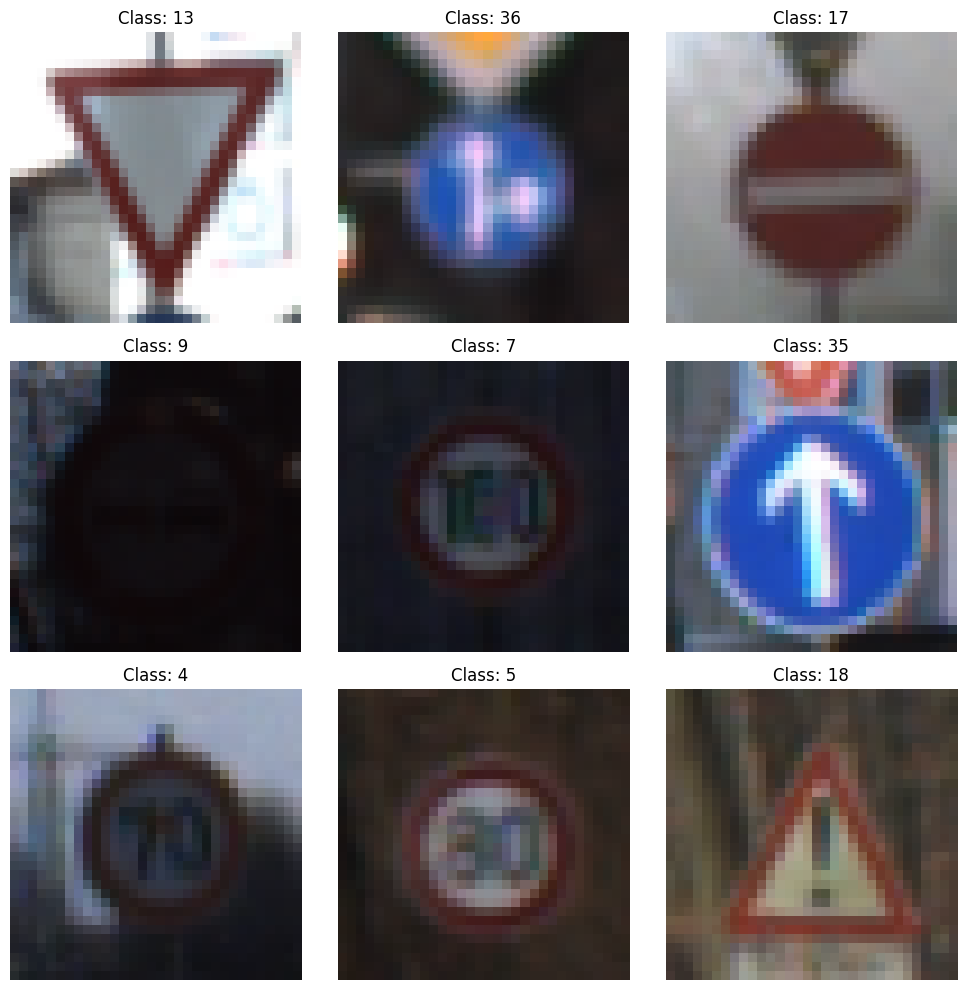

In [7]:
# Visualize random images from the dataset
def visualize_images(dataset, num_images=9, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """
    Visualizes random images from the dataset after reversing normalization.
    Args:
        dataset: The dataset to visualize images from.
        num_images: Number of images to display.
        mean: Mean used for normalization (tuple of 3 values for RGB).
        std: Standard deviation used for normalization (tuple of 3 values for RGB).
    """
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]

        # Reverse normalization
        for channel in range(image.size(0)):  # Iterate over RGB channels
            image[channel] = image[channel] * std[channel] + mean[channel]

        # Convert tensor to numpy array and permute dimensions to HxWxC
        image_np = image.permute(1, 2, 0).numpy()

        # Clip values to [0, 1] range to avoid warnings
        image_np = np.clip(image_np, 0, 1)

        plt.subplot(3, 3, i + 1)
        plt.imshow(image_np)
        plt.title(f"Class: {label}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Call the function with your training dataset
visualize_images(train_dataset)


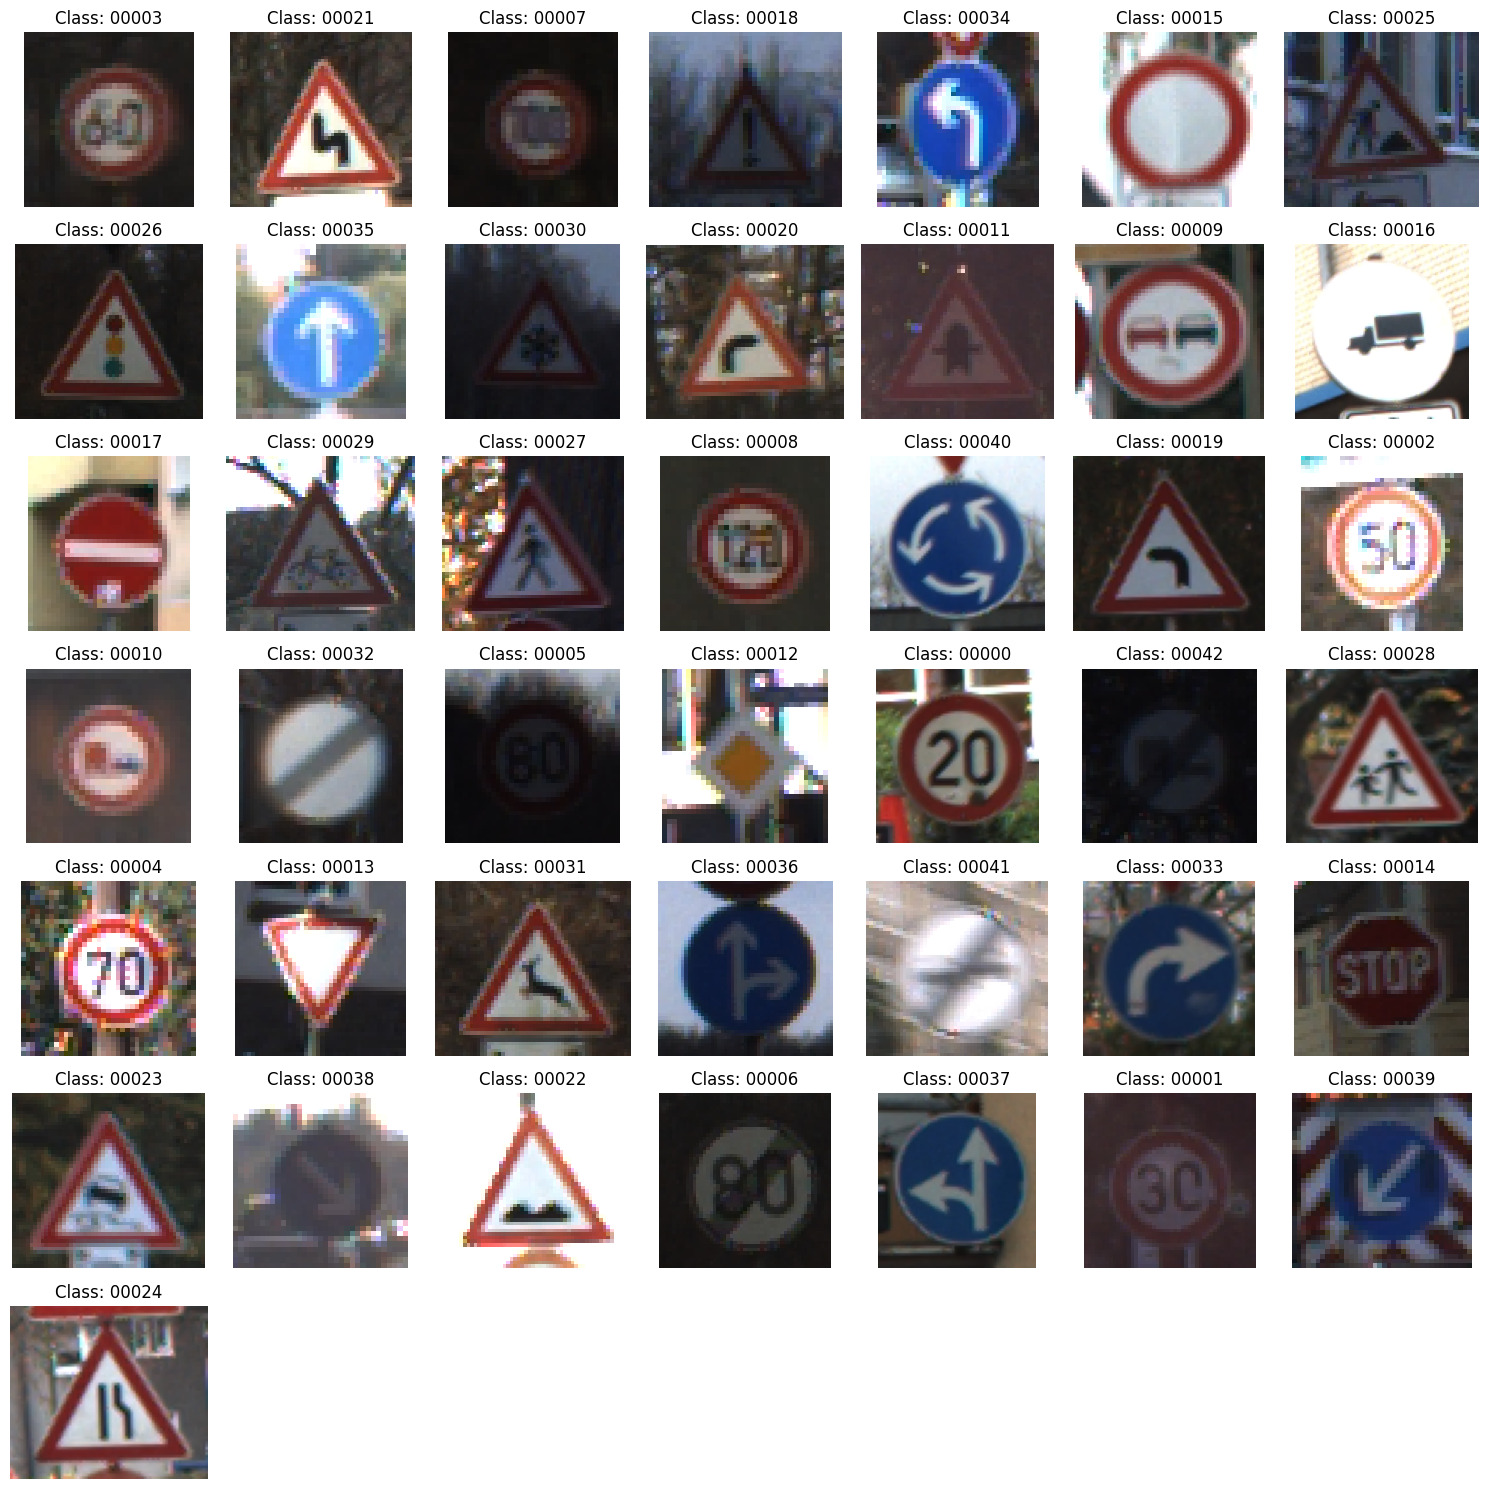

In [26]:

dataset_path = "/content/GTSRB/Final_Training/Images"

# Get the list of class directories
class_directories = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Initialize a dictionary to store one image per class
class_images = {}

# Loop through each class directory and pick one image
for class_dir in class_directories:
    class_path = os.path.join(dataset_path, class_dir)
    images = [f for f in os.listdir(class_path) if f.endswith('.ppm') or f.endswith('.jpg') or f.endswith('.png')]
    if images:
        # Pick the first image from the directory
        class_images[class_dir] = os.path.join(class_path, images[0])

# Display one image per class
plt.figure(figsize=(15, 15))  # Adjust figure size based on number of classes
for i, (class_name, image_path) in enumerate(class_images.items()):
    image = Image.open(image_path)
    plt.subplot(7, 7, i + 1)  # Adjust grid size based on number of classes (e.g., 7x7 for 43 classes)
    plt.imshow(image)
    plt.title(f"Class: {class_name}")
    plt.axis("off")
plt.tight_layout()
plt.show()


## Check Color Channels
Verify that all images are in RGB format.

In [8]:
def check_color_channels(dataset):
    for idx in range(len(dataset)):
        image, _ = dataset[idx]
        if image.shape[0] != 3:  # Check if channels are not RGB
            print(f"Non-RGB image found at index {idx}")
            break

check_color_channels(train_dataset)


## Checking sample distribution across training, validation, and testing datasets

In [9]:
# Check sample distribution across training, validation, and testing datasets
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

# Calculate the total number of samples
total_samples = train_size + val_size + test_size

# Calculate the percentage distribution
train_percentage = (train_size / total_samples) * 100
val_percentage = (val_size / total_samples) * 100
test_percentage = (test_size / total_samples) * 100

print(f"Training Samples: {train_size} ({train_percentage:.2f}%)")
print(f"Validation Samples: {val_size} ({val_percentage:.2f}%)")
print(f"Testing Samples: {test_size} ({test_percentage:.2f}%)")


Training Samples: 31367 (80.00%)
Validation Samples: 3920 (10.00%)
Testing Samples: 3922 (10.00%)


## Checking Class Distribution

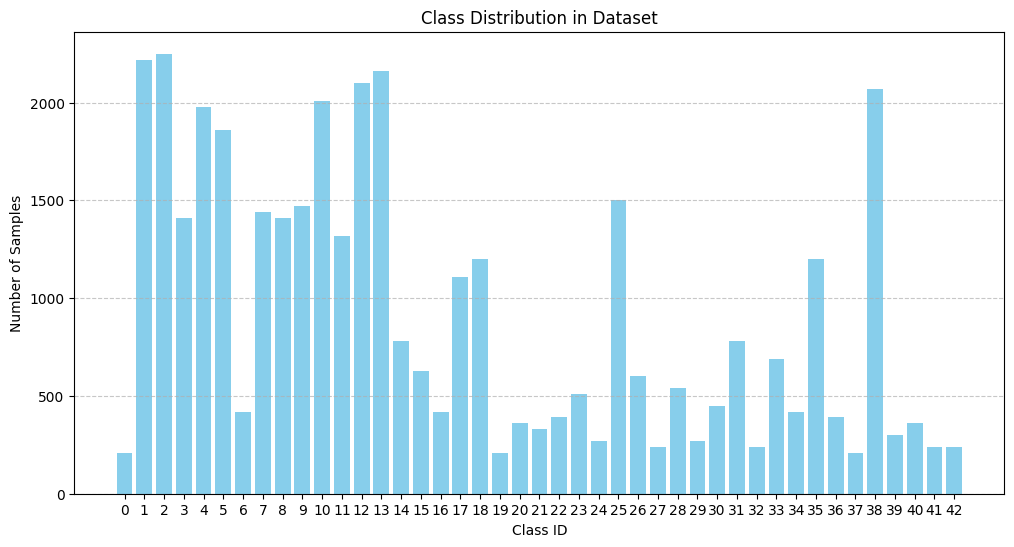

In [10]:

# Count the number of samples per class
def count_classes(dataset):
    class_counts = Counter()
    for _, label in dataset:
        class_counts[label] += 1
    return class_counts

# Get class counts for the entire dataset (or specific splits like train_dataset)
class_counts = count_classes(dataset)

# Sort classes by their ID for better visualization
sorted_classes = sorted(class_counts.items())

# Extract class IDs and their corresponding counts
class_ids = [item[0] for item in sorted_classes]
counts = [item[1] for item in sorted_classes]

# Plot the class distribution using a bar chart
plt.figure(figsize=(12, 6))
plt.bar(class_ids, counts, color='skyblue')
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Dataset')
plt.xticks(class_ids)  # Ensure all class IDs are labeled on the x-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Defining CNN model

In [27]:
import torch
from torchvision.models import mobilenet_v2

# Load pre-trained MobileNet v2
model = mobilenet_v2(weights="IMAGENET1K_V1")  # Use pre-trained weights

# Modify the final classifier layer to match the number of classes in your dataset
num_classes = 43  # Replace with your actual number of classes
model.classifier[1] = torch.nn.Linear(model.last_channel, num_classes)

# Move model to device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 37.0MB/s]


## Fine-Tune MobileNet v2

In [28]:
# Freeze all layers except the classifier
for param in model.features.parameters():
    param.requires_grad = False

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:  # Assuming train_loader is defined
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/10], Loss: 2.3504
Epoch [2/10], Loss: 2.0472
Epoch [3/10], Loss: 1.9851
Epoch [4/10], Loss: 1.9678
Epoch [5/10], Loss: 1.9570
Epoch [6/10], Loss: 1.9611
Epoch [7/10], Loss: 1.9646
Epoch [8/10], Loss: 1.9363
Epoch [9/10], Loss: 1.9412
Epoch [10/10], Loss: 1.9592


## training vs validation loss

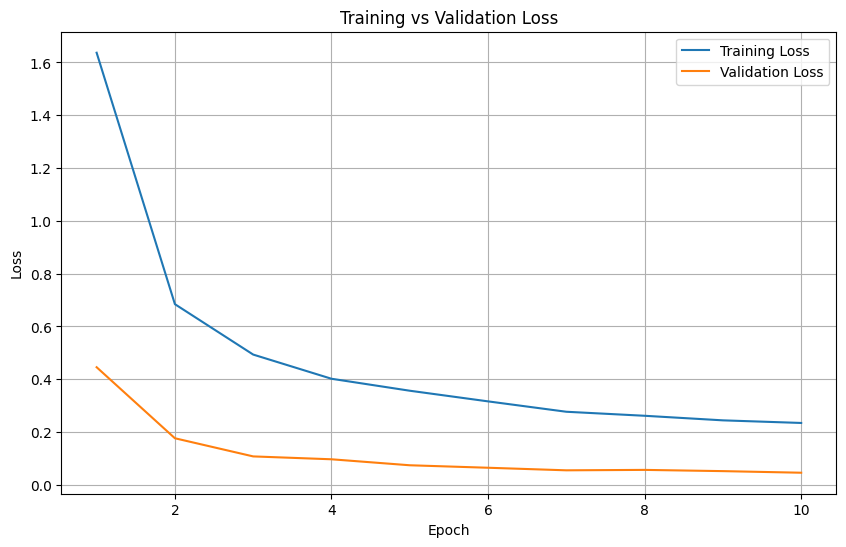

In [13]:
# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


## Model Testing

In [14]:
# Test the model on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 98.80%


## Save and Load Model

In [29]:
torch.save(model.state_dict(), "mobilenet_v2_traffic_signs.pth")


In [25]:
# Define your model architecture (same as used during training)
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes=43):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(64 * 8 * 8, 256)
        self.dropout = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(torch.nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool2(torch.nn.ReLU()(self.bn2(self.conv2(x))))
        x = torch.flatten(x, start_dim=1)
        x = torch.nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model and load weights
model = SimpleCNN(num_classes=43)  # Replace with your number of classes
model.load_state_dict(torch.load("traffic_sign_model.pth"))
model.eval()
print("Model loaded successfully!")


Model loaded successfully!


In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Evaluate the model on the test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert predictions and labels to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')  # Weighted accounts for class imbalance
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F1-Score: 0.99
